In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from basin_volume import *
from basin_volume.math import *

In [2]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg):
    def kl_fn(a, b):
        params_q = a + b
        logits_q = apply_fn(params_q, x)
        logprobs_q = jax.nn.log_softmax(logits_q)
        kl_term = optax.kl_divergence(logprobs_q, probs_p).mean()
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg):
    logits_p = apply_fn(params_p, x)
    probs_p = jax.nn.softmax(logits_p)
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg)

## Model-specific setup

In [3]:
# we can set mesa_constrain=True and norm_scale=(float) to clamp the norm of the parameters
# instead, we'll add an L2 penalty to the loss function here:
cfg = MLPTrainConfig(train_size=1024, 
                     opt="adam", 
                     lr=.05,
                     l2_reg=5e-4,
                     d_inner=64*8,
                     num_layers=5,
                    )

In [4]:
# Train the model
# This needs a refactor -- all the messiness is hiding in training.py
# You don't need to worry about it to use this package with other models

final_params, state, apply_fn, X_train = train_mlp(cfg)

E1217 20:27:13.665133   12693 cuda_blas.cc:193] failed to create cublas handle: the resource allocation failed
E1217 20:27:13.665190   12693 cuda_blas.cc:196] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
E1217 20:27:13.665240   12693 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: INTERNAL: Failed to initialize BLAS support


XlaRuntimeError: INTERNAL: Failed to initialize BLAS support

In [5]:
print(final_params.raveled.shape)

(1089034,)


In [6]:
kl_fn = make_kl_fn_params(final_params.raveled, apply_fn, X_train, l2_reg=0.)

In [7]:
# H = jax.hessian(kl_fn, argnums=0)(final_params.raveled, 0)

In [7]:
adam_state, _, schedule_state = state.opt_state
mu, nu = adam_state.mu['p'], adam_state.nu['p']

# standard deviation of the Gaussian we'll use to weight our estimates
sigma_epoch = 1/jnp.sqrt(cfg.l2_reg * cfg.train_size)

## Volume estimation

In [8]:
CUTOFF = 1e-2

RESULTS = {} # estimates, props, mults, deltas, logabsint

In [138]:
RESULTS['naive'] = get_estimates_vectorized_gauss(1000, 
                                                  sigma=sigma_epoch,
                                                  fn=kl_fn, 
                                                  params=final_params.raveled, 
                                                  cutoff=CUTOFF,
                                                  tol=0.1,
                                                  debug=False,
                                                 )


In [18]:
Array = jnp.array
float32 = jnp.float32

In [42]:
gaussint_ln_noncentral_erf(a=0.5120001, b=-0.03600831, n=1089033, x1=28.148438, c=-15347.044)

Array(3619077.2, dtype=float32)

In [99]:
a= 0.5120000839233398
b= -0.14776533842086792
n= 1089033
x1= 32.42888259887695
c= -15347.0439453125
debug = True
tol = 1e-3


a = 0.5120000839233398
b = 0.20120297372341156
n= 1089033
x1 = 20.087709426879883
c = -15347.0439453125

gaussint_ln_noncentral_erf(a, b, n, x1, c, debug=debug, tol=tol)

global_max=Array(1458.6262, dtype=float32, weak_type=True), global_in_range=Array(False, dtype=bool, weak_type=True)

Catastrophic cancellation in rad_x1, using linear approximation

approx error debug:
a = 0.5120000839233398
b = 0.20120297372341156
n = 1089033
x1 = 20.087709426879883
c = -15347.0439453125


ValueError: Approximation error too high, raise tol or investigate

In [130]:

a = 0.5120000839233398
b = 0.17222583293914795
n = 1089033
x1 = 94.98286437988281
c = -15347.0439453125

debug = True
tol = 1e-2

mu = b / a
center = mu / 2
dist = jnp.sqrt(mu**2 + 4 * n / a) / 2
global_max = center + dist
global_in_range = global_max <= x1
if debug:
    print(f"{global_max=}, {global_in_range=}")
max_pt = jnp.minimum(global_max, x1)
# get approximation stuff
log_fn = log_fn_rel_factory(a, b, n, max_pt)
dlog_fn = dlog_fn_factory(a, b, n)
d2log_fn = d2log_fn_factory(a, b, n)
f0 = log_fn(max_pt)
f1 = dlog_fn(max_pt)
f2 = d2log_fn(max_pt)
approx_log_fn = lambda x: f0 + f1 * (x - max_pt) + 1/2 * f2 * (x - max_pt)**2

constant_term = log_fn_factory(a, b, n)(max_pt) + c

# global in range:
# extrapolate down by tol
y_tol = -jnp.log(tol)
rad_global = jnp.sqrt(2 * y_tol / -f2)
check_low_global = jnp.clip(max_pt - rad_global, 0, x1)
check_high_global = jnp.clip(max_pt + rad_global, 0, x1)
# check approximation error at those points
error_low_global = log_fn(check_low_global) - approx_log_fn(check_low_global)
error_high_global = log_fn(check_high_global) - approx_log_fn(check_high_global)
abs_error_global = jnp.maximum(jnp.abs(error_low_global), jnp.abs(error_high_global))

# global out of range:
# extrapolate down by tol
rad_x1 = f1 / -f2 - jnp.sqrt(f1**2 / f2**2 + 2 * y_tol / -f2)
if jnp.any(~global_in_range & (jnp.abs(f1/-f2) > 1e5 * jnp.minimum(jnp.abs(y_tol / f1), jnp.abs(rad_x1)))):
    # catastrophic cancellation in rad_x1, use linear approximation
    if debug:
        print()
        print("Catastrophic cancellation in rad_x1, using linear approximation")
    rad_x1 = -y_tol / f1
check_x1 = jnp.clip(max_pt + rad_x1, 0, None)
# check approximation error at that point
abs_error_x1 = jnp.abs(log_fn(check_x1) - approx_log_fn(check_x1))

# branch
abs_error = jnp.where(global_in_range, abs_error_global, abs_error_x1)
if jnp.any(abs_error > tol):
    # check accuracy of approximation; in practice tol is extremely conservative
    # empirically, tol of 0.03 is still accurate to about +-1e-7 in the log
    # (based on comparison to _normed for n=12_000, a=2, b=3, x1=100)
    # i.e. beyond fp32 and approaching fp64 precision
    # also, we only actually need to be accurate to maybe +-1 in the log!
    if debug:
        print()
        print("approx error debug:")
        idx = abs_error > tol
        for name, var in zip(["a", "b", "n", "x1", "c"], [a, b, n, x1, c]):
            if isinstance(var, jnp.ndarray):
                if var.ndim == 1:
                    print(f"{name} = {var[idx][0]}")
                else:
                    print(f"{name} = {var}")
            else:
                print(f"{name} = {var}")
    raise ValueError("Approximation error too high, raise tol or investigate")

# use erf to integrate
if debug:
    print()
    print("f012_int_ln inputs:")
    print(f"{max_pt = }\n{x1 = }\n{f0 = }\n{f1 = }\n{f2 = }\n{c = }")
print(f012_int_ln(max_pt, x1, f0, f1, f2, debug=debug) + constant_term)


global_max=Array(1458.5979, dtype=float32, weak_type=True), global_in_range=Array(False, dtype=bool, weak_type=True)

Catastrophic cancellation in rad_x1, using linear approximation

approx error debug:
a = 0.5120000839233398
b = 0.17222583293914795
n = 1089033
x1 = 94.98286437988281
c = -15347.0439453125


ValueError: Approximation error too high, raise tol or investigate

In [71]:
a= 0.5120000839233398
b= -0.14776533842086792
n= 1089033
x1= 32.42888259887695
c= -15347.0439453125


a = 0.5120000839233398
b = 0.20120297372341156
n= 1089033
x1 = 20.087709426879883
c = -15347.0439453125

debug = True
tol = 1e-2

mu = b / a
center = mu / 2
dist = jnp.sqrt(mu**2 + 4 * n / a) / 2
global_max = center + dist
global_in_range = global_max <= x1
if debug:
    print(f"{global_max=}, {global_in_range=}")
max_pt = jnp.minimum(global_max, x1)
# get approximation stuff
log_fn = log_fn_factory(a, b, n)
dlog_fn = dlog_fn_factory(a, b, n)
d2log_fn = d2log_fn_factory(a, b, n)
f0 = log_fn(max_pt)
f1 = dlog_fn(max_pt)
f2 = d2log_fn(max_pt)
approx_log_fn = lambda x: f0 + f1 * (x - max_pt) + 1/2 * f2 * (x - max_pt)**2

# global in range:
# extrapolate down by tol
y_tol = -jnp.log(tol)
rad_global = jnp.sqrt(2 * y_tol / -f2)
check_low_global = jnp.clip(max_pt - rad_global, 0, x1)
check_high_global = jnp.clip(max_pt + rad_global, 0, x1)
# check approximation error at those points
error_low_global = log_fn(check_low_global) - approx_log_fn(check_low_global)
error_high_global = log_fn(check_high_global) - approx_log_fn(check_high_global)
abs_error_global = jnp.maximum(jnp.abs(error_low_global), jnp.abs(error_high_global))

# global out of range:
# extrapolate down by tol
rad_x1 = f1 / -f2 - jnp.sqrt(f1**2 / f2**2 + 2 * y_tol / -f2)
if jnp.any(~global_in_range & (jnp.abs(f1/-f2) > 1e5 * jnp.minimum(jnp.abs(y_tol / f1), jnp.abs(rad_x1)))):
    # catastrophic cancellation in rad_x1, use linear approximation
    if debug:
        print()
        print("Catastrophic cancellation in rad_x1, using linear approximation")
    rad_x1 = -y_tol / f1
# point to check; 1e-3 is to avoid float precision issues, any nonnegative value is valid
# (too small and we'll get rounding issues, too large and the actual error will be too high)
check_x1 = jnp.clip(max_pt + rad_x1, 0, max_pt - 1e-3)

global_max=Array(1458.6262, dtype=float32, weak_type=True), global_in_range=Array(False, dtype=bool, weak_type=True)

Catastrophic cancellation in rad_x1, using linear approximation


In [84]:
f012_int_ln(max_pt, x1, f0, f1, f2, debug=debug), c


f012_int_ln terms:
upper = Array(3267106.8, dtype=float32)
lower = Array(1633655.8, dtype=float32)


(Array(3267106.8, dtype=float32), -15347.0439453125)

In [137]:
f0, f1, f2

(Array(0., dtype=float32, weak_type=True),
 Array(11417.115, dtype=float32, weak_type=True),
 Array(-121.22403, dtype=float32, weak_type=True))

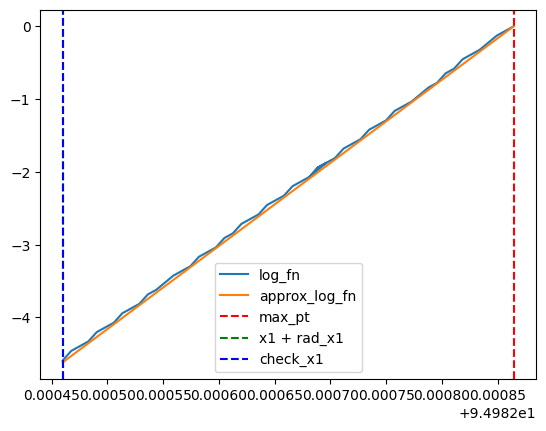

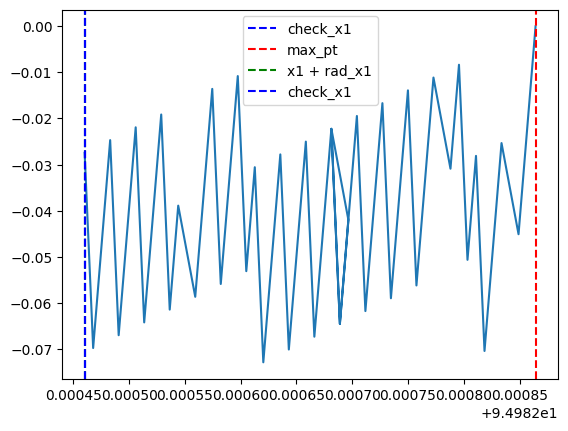

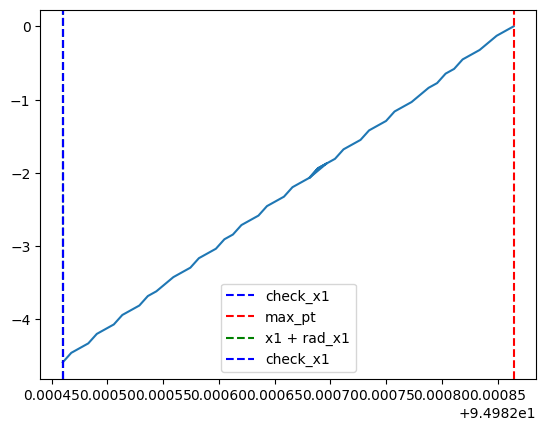

In [133]:
xs = jnp.linspace(check_x1, x1, 1000)
plt.plot(xs, log_fn(xs) - log_fn(max_pt), label="log_fn")
plt.plot(xs, approx_log_fn(xs) - log_fn(max_pt), label="approx_log_fn")
# plt.plot(xs, -a/2 * xs**2 + b*xs, label="-a/2 x^2 + bx")
#plt.plot(xs, n * jnp.log(jnp.abs(xs / max_pt)), label="n log |x|")
#plt.ylim(bottom=(approx_log_fn(xs).min() - log_fn(max_pt)))
plt.axvline(x=x1, color='r', linestyle='--', label="max_pt")
plt.axvline(x=x1 + rad_x1, color='g', linestyle='--', label="x1 + rad_x1")
plt.axvline(x=check_x1, color='b', linestyle='--', label="check_x1")
plt.legend()
plt.show()

plt.plot(xs, approx_log_fn(xs) - log_fn(xs))
plt.axvline(x=check_x1, color='b', linestyle='--', label="check_x1")
plt.axvline(x=x1, color='r', linestyle='--', label="max_pt")
plt.axvline(x=x1 + rad_x1, color='g', linestyle='--', label="x1 + rad_x1")
plt.axvline(x=check_x1, color='b', linestyle='--', label="check_x1")
plt.legend()
plt.show()

plt.plot(xs, log_fn(xs))
plt.axvline(x=check_x1, color='b', linestyle='--', label="check_x1")
plt.axvline(x=x1, color='r', linestyle='--', label="max_pt")
plt.axvline(x=x1 + rad_x1, color='g', linestyle='--', label="x1 + rad_x1")
plt.axvline(x=check_x1, color='b', linestyle='--', label="check_x1")
plt.legend()
plt.show()


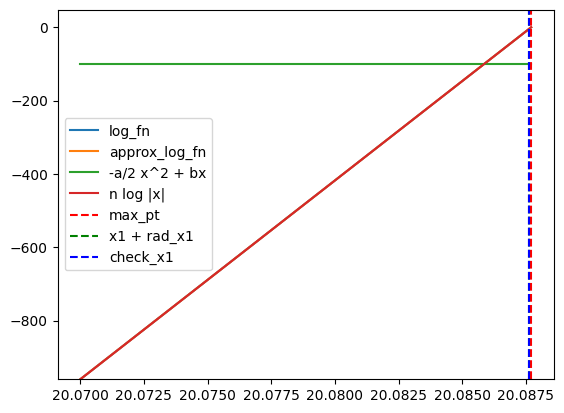

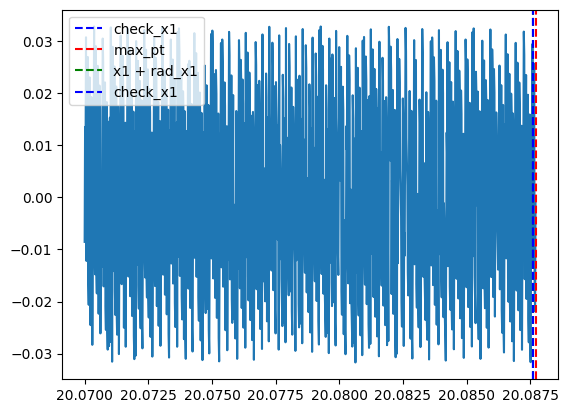

In [103]:
xs = jnp.linspace(20.07, x1, 1000)
plt.plot(xs, log_fn(xs) - log_fn(max_pt), label="log_fn")
plt.plot(xs, approx_log_fn(xs) - log_fn(max_pt), label="approx_log_fn")
plt.plot(xs, -a/2 * xs**2 + b*xs, label="-a/2 x^2 + bx")
plt.plot(xs, n * jnp.log(jnp.abs(xs / max_pt)), label="n log |x|")
plt.ylim(bottom=(approx_log_fn(xs).min() - log_fn(max_pt)))
plt.axvline(x=x1, color='r', linestyle='--', label="max_pt")
plt.axvline(x=x1 + rad_x1, color='g', linestyle='--', label="x1 + rad_x1")
plt.axvline(x=check_x1, color='b', linestyle='--', label="check_x1")
plt.legend()
plt.show()

plt.plot(xs, approx_log_fn(xs) - log_fn(xs))
plt.axvline(x=check_x1, color='b', linestyle='--', label="check_x1")
plt.axvline(x=x1, color='r', linestyle='--', label="max_pt")
plt.axvline(x=x1 + rad_x1, color='g', linestyle='--', label="x1 + rad_x1")
plt.axvline(x=check_x1, color='b', linestyle='--', label="check_x1")
plt.legend()
plt.show()


In [77]:
log_fn(check_x1), approx_log_fn(check_x1), log_fn(max_pt)


(Array(3267063.2, dtype=float32, weak_type=True),
 Array(3267063.5, dtype=float32, weak_type=True),
 Array(3267117.8, dtype=float32, weak_type=True))

In [79]:
log_fn(check_x1) - approx_log_fn(check_x1)

Array(-0.25, dtype=float32, weak_type=True)

In [81]:
x = check_x1
-a/2 * x**2, b*x, n * jnp.log(jnp.abs(x))

(Array(-103.289856, dtype=float32, weak_type=True),
 Array(4.041506, dtype=float32, weak_type=True),
 Array(3267162.5, dtype=float32, weak_type=True))

In [82]:
dlog_fn_factory(a, b, n)(check_x1)


Array(54206.51, dtype=float32, weak_type=True)

In [69]:
print(rad_x1)
print(f1 / -f2, - jnp.sqrt(f1**2 / f2**2 + 2 * y_tol / -f2))

-8.583069e-05
20.080166 -20.080252


In [12]:
-y_tol / f1

Array(-0.0001372, dtype=float32, weak_type=True)

In [55]:
f0, f1, f2

(Array(3788525.8, dtype=float32, weak_type=True),
 Array(33565.44, dtype=float32, weak_type=True),
 Array(-1036.0763, dtype=float32, weak_type=True))

In [38]:
(jnp.abs(f1/-f2), jnp.abs(y_tol / f1))

(Array(28.127447, dtype=float32, weak_type=True),
 Array(0.00011908, dtype=float32, weak_type=True))

In [63]:
f012_int_ln(max_pt, x1, f0, f1, f2, debug=debug) + c

upper=Array(3788515.2, dtype=float32), lower=Array(2155239.2, dtype=float32)


Array(3773168.2, dtype=float32)

In [13]:
print(f"{max_pt = }\n{x1 = }\n{f0 = }\n{f1 = }\n{f2 = }\n{c = }")
print(f"{(x1 - max_pt).item() =}")

max_pt = Array(32.428883, dtype=float32, weak_type=True)
x1 = 32.42888259887695
f0 = Array(3788525.8, dtype=float32, weak_type=True)
f1 = Array(33565.44, dtype=float32, weak_type=True)
f2 = Array(-1036.0763, dtype=float32, weak_type=True)
c = -15347.0439453125
(x1 - max_pt).item() =0.0


In [17]:
x1 == max_pt

Array(True, dtype=bool, weak_type=True)

In [25]:
print(f"{abc_int_ln(0, -f2, f1, f0) = }")
print(f"{abc_int_ln(-max_pt, -f2, f1, f0) = }")

abc_int_ln(0, -f2, f1, f0) = Array(3788515.2, dtype=float32)
abc_int_ln(-max_pt, -f2, f1, f0) = Array(2155239.2, dtype=float32)


In [36]:
f0, f1, f2
aa, bb, cc = -f2, f1, f0
scaled_cdf_ln(0, bb/aa, 1/jnp.sqrt(aa))

Array(-543715.9, dtype=float32)

In [37]:
standard_cdf_ln(0)

Array(-0.6931472, dtype=float32)

In [38]:
erfc_ln(0)

Array(0., dtype=float32)

In [39]:
sp.special.erfcx(0)

np.float64(1.0)

In [49]:
jnp.exp(standard_cdf_ln(0))

Array(0.5, dtype=float32)

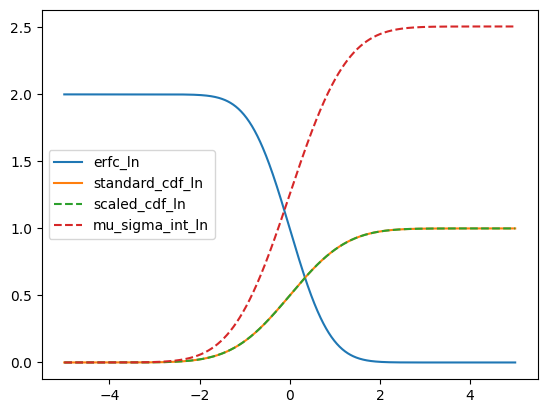

In [55]:
z = jnp.linspace(-5, 5, 1000)
plt.plot(z, jnp.exp(erfc_ln(z)), label="erfc_ln")
plt.plot(z, jnp.exp(standard_cdf_ln(z)), label="standard_cdf_ln")
plt.plot(z, jnp.exp(scaled_cdf_ln(z, 0, 1)), '--', label="scaled_cdf_ln")
plt.plot(z, jnp.exp(mu_sigma_int_ln(z, 0, 1)), '--', label="mu_sigma_int_ln")
plt.legend()
plt.show()

In [23]:
for x in [0, .0001, .001, .01, .1]:
    print(f"{x = }")
    print(f"{abc_int_ln(x, -f2, f1, f0) = }")

x = 0
abc_int_ln(x, -f2, f1, f0) = Array(3788515.2, dtype=float32)
x = 0.0001
abc_int_ln(x, -f2, f1, f0) = Array(3788518.5, dtype=float32)
x = 0.001
abc_int_ln(x, -f2, f1, f0) = Array(3788548.8, dtype=float32)
x = 0.01
abc_int_ln(x, -f2, f1, f0) = Array(3788850.8, dtype=float32)
x = 0.1
abc_int_ln(x, -f2, f1, f0) = Array(3791866.5, dtype=float32)


In [ ]:
final_params.raveled.shape

(1089034,)

In [52]:
P_adam_mu = diag_preconditioner(mu, eps=4e-3, exponent=0.3)
RESULTS['adam_mu'] = get_estimates_vectorized_gauss(100, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_adam_mu, 
                                                    fn=kl_fn, 
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF,
                                                    tol=10,
                                                    )


2024-12-13 02:42:03.742735: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below -4.07TiB (-4470416519688 bytes) by rematerialization; only reduced to 4.31TiB (4743980212624 bytes), down from 4.31TiB (4743980212624 bytes) originally
2024-12-13 02:42:03.744528: E external/xla/xla/status_macros.cc:56] INTERNAL: RET_CHECK failure (external/xla/xla/service/gpu/fusions/fusion_emitter.cc:95) device_info.block_dim_limit().x == 0 || launch_dims.block_counts().x < device_info.block_dim_limit().x Kernel 'loop_select_fusion' launch needs more blocks (2316396589) than allowed by hardware (2147483647).
*** Begin stack trace ***
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	PyObject_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	PyObject_Vectorcall
	
	
	
	
	
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	_PyF

XlaRuntimeError: INTERNAL: RET_CHECK failure (external/xla/xla/service/gpu/fusions/fusion_emitter.cc:95) device_info.block_dim_limit().x == 0 || launch_dims.block_counts().x < device_info.block_dim_limit().x Kernel 'loop_select_fusion' launch needs more blocks (2316396589) than allowed by hardware (2147483647).

In [19]:
P_adam_nu = diag_preconditioner(nu, eps=2e-3, exponent=0.3)
RESULTS['adam_nu'] = get_estimates_vectorized_gauss(3000, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_adam_nu, 
                                                    fn=kl_fn, 
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF)


## Plots

In [21]:
def scaled_histogram(values, label, settings):
    nbins = int(jnp.sqrt(len(values)))
    # if label == 'hessian':
    #     nbins = 5
    counts, bins = jnp.histogram(values, bins=nbins)
    counts = counts / counts.max()
    plt.stairs(counts, bins, **dict(settings, label=label))

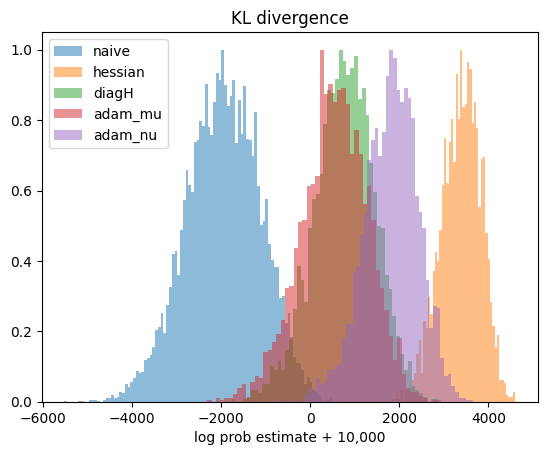

In [23]:
settings = {'alpha': 0.5, 'fill': True}
for label, results in RESULTS.items():
    # if label in ['hessian', 'adam_mu']:
    #     continue
    these_settings = dict(settings, label=label)
    scaled_histogram(results[0] + 10_000, label, these_settings)
plt.xlabel("log prob estimate + 10,000")
plt.legend()
plt.title("KL divergence")
plt.show()